## Spatial Null Models

* When working with parcellated data, the null framework that seems to consistently yield statistical estimates with the lowest error rate is the Cornblath method.
* When working with vertex-level data, the optimal null method appears to be the framework proposed by Alexander-Bloch et al., 2018
* However, if you have volumetric, subcortical, cerebellar, or region-of-interest data you can only use the parameterized data models in these situations. Here, we find that the Moran and Burt-2020 methods seem to fare rather comparably
        - https://markello-spatialnulls.netlify.app/recommendations.html

---
### example with surface data

In [1]:
import neuromaps
import nibabel as nib
from neuromaps import nulls
from scipy import stats
import numpy as np

In [2]:
civet1 = neuromaps.datasets.fetch_annotation(source='reardon2018', desc='scalinghcp')
civet2 = neuromaps.datasets.fetch_annotation(source='reardon2018', desc='scalingnih')

In [3]:
# array data from civet1, civet2 annotations

img_civet1a = nib.load(civet1[0])
img_civet1b = nib.load(civet1[1])
img_civet1 = img_civet1a.agg_data() + img_civet1b.agg_data()

img_civet2a = nib.load(civet2[0])
img_civet2b = nib.load(civet2[1])
img_civet2 = img_civet2a.agg_data() + img_civet2b.agg_data()

---
## Naive Models

#### parametric - scipy pearsonr

In [4]:
# input must be array-like, same length
r, p = stats.pearsonr(img_civet1,img_civet2)
print(f'Correlation: {r}, P-value: {p}')

Correlation: 0.5343663262765331, P-value: 0.0


#### non-parametric - neuromaps stats method
Calculates two-tailed p-value for hypothesis of whether samples a and b are related using permutation tests.

In [5]:
# input must be array-like, same length
r, p = neuromaps.stats.permtest_metric(img_civet1, img_civet2)

In [6]:
r, p

(0.5343663096427917, 0.000999000999000999)

---
## Spatial permutation models

#### neuromaps compare_images with null model

In [7]:
rotated = nulls.alexander_bloch(civet1, atlas='civet', density='41k',
                                n_perm=100, seed=1234)

r, p = neuromaps.stats.compare_images(civet1,civet2, nulls=rotated)
print(f'Correlation: {r}, P-value: {p}')

Correlation: 0.3770379047549592, P-value: 0.009900990099009901


#### vs. neuromaps compare_images without providing a null model

In [8]:
r1 = neuromaps.stats.compare_images(civet1,civet2)
print(f'Correlation: {r1}')

Correlation: 0.3770379047549592


In [9]:
AD = nib.load('data/neurosynth_maps/terms/alzheimer_association-test_z_FDR_0.01.nii')
age = nib.load('data/neurosynth_maps/terms/age_uniformity-test_z_FDR_0.01.nii')

In [10]:
from neuromaps import stats

In [12]:
import abagen
atlas = abagen.fetch_desikan_killiany()

In [13]:
from neuromaps.parcellate import Parcellater
parc = Parcellater(atlas['image'],'mni152')
AD_p = parc.fit_transform(AD,'mni152')
age_p = parc.fit_transform(age,'mni152')

In [14]:
stats.compare_images(AD_p, age_p)

-0.19654383819873872

In [23]:
stats.permtest_metric(AD_p[0], age_p[0])

(-0.20520221954681284, 0.059940059940059943)

In [46]:
age_p[0].shape

(83,)

In [47]:
import statsmodels.api as sm

#calculate autocorrelations
x = sm.tsa.acf(age_p[0])

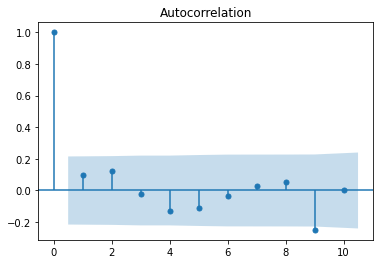

In [96]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(age_p[0], lags=10)
plt.show()

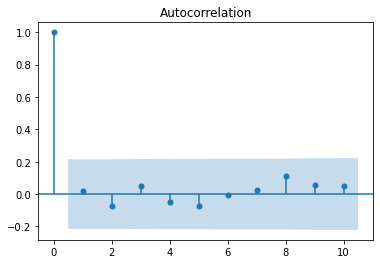

In [117]:
#plot autocorrelation function
fig = tsaplots.plot_acf(AD_p[0], lags=10)
plt.show()

In [92]:
''' numpy.correlate '''

import numpy

x = np.array(AD_p[0]) 

# Mean
mean = numpy.mean(AD_p[0])

# Variance
var = numpy.var(AD_p[0])

# Normalized data
ndata = AD_p[0] - mean

acorr = numpy.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
acorr = acorr / var / len(ndata)